# Project - Market Day

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" align="left" src="https://i.creativecommons.org/l/by-sa/4.0/80x15.png" /></a>&nbsp;| Dennis G. Wilson | <a href="https://supaerodatascience.github.io/stochastic/">https://supaerodatascience.github.io/stochastic/</a>


![Stardew Valley](https://venturebeat.com/wp-content/uploads/2018/01/sw7rtba7p1xs77klsime.png)


It is Market Day! You've been working hard for a whole season, planting, watering, and taking care of crops. Now it is time to sell them in town. Just one problem though - your old truck can only carry so much weight. Which crops should you bring to maximize your profits?


In this project, you will use a stochastic algorithm of your choice to find the best crop configuration you can load into your truck. You know how much stock you have of each crop, how much each crop weighs, and what price it will fetch at the market. You should use these values throughout the project.


Before we start, if you're using colab to run this notebook, you'll need to uncomment and run the following lines:


In [100]:
from typing import Dict, List, Callable

import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import pandas as pd
from mpl_toolkits import mplot3d

import pickle


In [2]:
class CountCalls: 
    def __init__(self, func): 
        self._count = 0 
        self._func = func 
    def __call__( self, *args, **kwargs): 
        self._count += 1 
        return self._func(*args,**kwargs) 
    @property 
    def call_count(self): 
        return self._count 
    
    def reset_count(self):
        self._count = 0


In [3]:
df = pd.read_csv("market.csv", index_col=0)
df.head()


,stock,weight,price_A,price_B,price_C
Apple,5,5,1.00,0.5,1.1
Apricot,65,3,0.50,0.2,0.6
Blueberry,5,3,0.50,0.3,1.2
Cactus Fruit,90,4,0.75,0.3,0.3
Cherry,15,4,0.80,0.4,1.1


In [4]:
stock = df["stock"].to_dict()
weight = df["weight"].to_dict()
price = df["price_A"].to_dict()


To evaluate your possible load going to the market, we will use a function that takes in a dictionary of this type, specifying how many of each crop you will take. This function will take into the constraints of having enough stock of the crop type and of not surpassing the weight limit.


In [5]:
@CountCalls
def evaluate(
    load: Dict[str, int],
    stock: Dict[str, int],
    weight: Dict[str, int],
    price: Dict[str, int],
    max_weight=5000,
):
    total_weight = 0
    total_price = 0
    for k in load:
        if load[k] <= stock[k]:
            total_price += load[k] * price[k]
            total_weight += load[k] * weight[k]
            if total_weight > max_weight:
                return 0
        else:
            return 0
    return total_price


You can try this with an example load generated randomly:


In [6]:
trial_load = {}
for k in stock:
    trial_load[k] = np.random.randint(0, stock[k])


total_weight = 0
for k in trial_load:
    if trial_load[k] <= stock[k]:
        total_weight += trial_load[k] * weight[k]
print(f"{total_weight=}")

evaluate(trial_load, stock, weight, price, 5000)


total_weight=3087


600.0000000000001

In [7]:
evaluate({"Apricot": 10}, stock, weight, price)


5.0

## Challenge 1

Use a stochastic algorithm to find the configuration of crops that maximizes profit while respecting the constraints of the weight limit and stock. You can use any of the class code or a library like `pymoo`. You should create a reasonable representation for the problem and appropriate modification functions like mutation and crossover. You can also modify the evaluation function, as long as your final solution is valid according to the weight and stock constraints.

Include your code for optimization, any visualizations of the optimization process, as well as code to show the final market load and profit gained. Can you beat the random trial load profits?

Hint: this is a constrained case of the [knapsack problem](https://en.wikipedia.org/wiki/Knapsack_problem)


In [8]:
def get_random_load(stock):
    """util function to generate a random load matching provided available stock"""
    load = {}
    for k in stock:
        load[k] = np.random.randint(0, stock[k])
    return load


# random search method

In [9]:
def random_search(n_steps, stock, weight, price, evaluate: Callable, max_weight=5000):
    """function to perform a random search to maximise objective evaluate"""
    best_score = 0
    best_load = {}
    scores = np.empty(n_steps)
    evaluate.reset_count()

    for i in range(n_steps):
        random_load = get_random_load(stock)
        score = evaluate(random_load, stock, weight, price, max_weight)
        if score > best_score:
            best_score = score
            best_load = random_load
        scores[i] = best_score
    return best_load, best_score, scores


obtained a load priced 957.65 with 100000 evaluations of objective


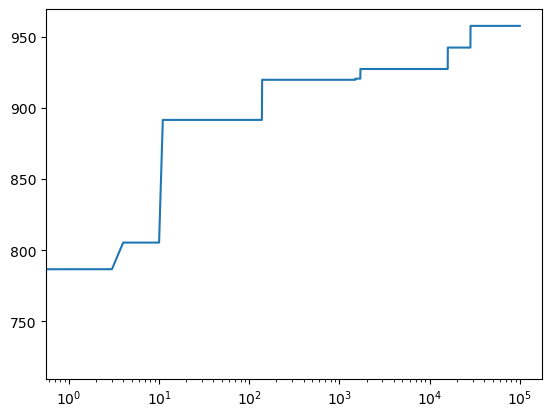

In [10]:
_, best_price, scores = random_search(100000, stock, weight, price, evaluate, 5000)
print(f"obtained a load priced {best_price:.2f} with {evaluate.call_count} evaluations of objective")
## best result yet : 981.55 with 100k iterations in ~5s

plt.plot(scores)
plt.xscale('log')

The results of random search are not that good. It takes *a lot* of evaluations to get a good result.

**We will try to use another method: genetic algorithm** to improve our results

In [11]:
def mutate(load: Dict[str, int], stock: Dict[str, int], proba=0.1):
    """
    permet d'avoir un chargement voisin qui respecte le stock
    ne modifie pas load, renvoie une nouvelle instance

    pour chaque culture ajoute + ou - 1 avec une probabilité proba,
    par défaut 10%, soit 5% pour +1 et 5% pour -1
    """
    new_load = load.copy()

    probas = np.random.rand(len(new_load.keys()))
    for idx, k in enumerate(new_load.keys()):
        if probas[idx] < proba / 2:
            # check if we can add 1 and still respect max load
            if stock[k] >= load[k] + 1:
                new_load[k] = load[k] + 1
        elif probas[idx] < proba:
            # check if we can subtract 1 and not be under 0
            if load[k] >= 0 + 1:
                new_load[k] = load[k] - 1

    return new_load


In [12]:
# example of what mutate changes in one load.
# In average it should change len(load)/proba (3.5) crop loads 
# (a little less in truth due to constraints on min/max values)

load = get_random_load(stock)
new_load = mutate(load, stock)

for k in load:
    if load[k] != new_load[k]:
        print(f"change to {k} load from {load[k]} to {new_load[k]}")


change to Starfruit load from 3 to 4
change to Kale load from 4 to 5
change to Wheat load from 36 to 35


In [13]:
def crossover(load1: Dict[str, int], load2: Dict[str, int]) -> Dict[str, int]:
    """
    crossover entre deux stocks

    prend aléatoirement (p=0.5) le chargement de load1 ou load2 pour chaque culture
    """
    child = {}
    probas = np.random.rand(len(new_load.keys()))

    for idx, k in enumerate(load1.keys()):
        if probas[idx] > 0.5:
            child[k] = load1[k]
        else:
            child[k] = load2[k]

    return child


In [14]:
def tournament_selection(
    population: List[Dict[str, int]], fitness: npt.NDArray, t_size=3
):
    """returns the best individual in a random subset of population of size t_size"""
    rng = np.random.default_rng()
    tournament = rng.choice(len(population), size=t_size)
    ind = tournament[
        np.argmax(fitness[tournament])
    ]  # keep in mind we have to maximise fitness
    return population[ind], fitness[ind]


In [15]:
def truncation_selection(population: List[Dict[str, int]], fitness: npt.NDArray, p=0.2):
    """returns the best p*len(population) individuals"""
    
    n_elites = int(np.floor(len(population) * p))

    elites = np.argsort(fitness)[-n_elites:]  # keep in mind we have to maximise fitness

    return population[elites], fitness[elites]


In [16]:
def genetic_algorithm(
    population: List[Dict[str, int]],
    stock: Dict[str, int],
    weight: Dict[str, int],
    price: Dict[str, int],
    fitness: npt.NDArray | None,
    max_weight=5000,
):
    """
    performs one iteration of genetic algorithm search
    """
    if fitness is None:
        fitness = np.empty(len(population))
        for idx, load in enumerate(population):
            fitness[idx] = evaluate(load, stock, weight, price, max_weight)

    next_pop, next_fitness = truncation_selection(population, fitness) # keep the 20% best individuals 

    while len(next_pop) < len(population):
        parent1, _ = tournament_selection(population, fitness)
        parent2, _ = tournament_selection(population, fitness)
        child = crossover(parent1, parent2)
        child = mutate(child, stock)
        next_pop = np.concatenate((np.array(next_pop), np.array([child])))
        next_fitness = np.concatenate(
            (next_fitness.flatten(), np.array([evaluate(child, stock, weight, price, max_weight)]))
        )

    return next_pop, next_fitness


In [17]:
n_gen = 1000
n_population = 70

population = np.array([get_random_load(stock) for _ in range(n_population)])
maxfit = np.zeros(n_gen)

fitness = None
evaluate.reset_count()
for i in range(n_gen):
    population, fitness = genetic_algorithm(
        population, stock, weight, price, fitness, 5000  # type: ignore
    )
    maxfit[i] = np.max(fitness)
    if i > 2 and maxfit[i] > maxfit[i - 1]:
        print(i, maxfit[i])

best_load = population[np.argmax(fitness)]  # type: ignore
print(f"obtained a load priced {maxfit[-1]:.2f} with {evaluate.call_count} evaluations of objective")

# best result 1141.95 in 5000 iterations with 100 population and default mutation params
# it does not seem like we can get better results with this algorithm and those params.


4 964.1500000000001
6 971.05
7 977.7500000000001
8 981.8000000000001
10 987.3000000000001
12 994.1500000000003
15 997.0
17 997.8000000000001
18 1000.25
19 1000.5000000000001
23 1003.4000000000001
26 1004.0500000000001
27 1004.1500000000001
28 1005.65
31 1007.5
32 1008.1999999999999
34 1008.5000000000001
35 1008.9
36 1009.5999999999999
37 1010.8999999999999
38 1012.25
41 1012.7
43 1015.1499999999997
44 1016.0
46 1016.3999999999999
47 1018.3
50 1019.0
51 1022.4
52 1023.2499999999999
54 1023.8499999999999
55 1024.45
56 1025.3500000000001
57 1027.55
60 1028.35
61 1029.6499999999999
62 1032.7
64 1032.8999999999999
65 1036.25
66 1036.5000000000002
68 1036.8
69 1039.0
71 1039.25
72 1039.95
73 1042.3
76 1043.6
79 1044.2
80 1045.4999999999998
81 1047.35
83 1047.8999999999999
84 1048.4999999999998
85 1051.1499999999999
86 1051.55
88 1052.9499999999998
90 1053.85
92 1054.45
93 1055.1999999999998
94 1055.8999999999999
96 1056.0499999999997
97 1058.85
101 1059.8
103 1061.3
107 1063.1000000000001
11

On obtient de **bien meilleurs résultats** qu'en random search, pour un nombre d'évaluations de la fonction objectif plus faible. Ce nombre d'évaluation est quand même assez conséquent, une augmentation de la proportion des meilleurs individus à garder (paramètre p dans truncation_selection) permettrait de le réduire. On pourrait aussi changer le type de crossover et les paramètres de mutation pour espérer avoir de meilleurs résultats.
<br><br>
On voit que la convergence est <b>rapide au début puis très lente</b>.<br>Peut-être faudra-il ajouter plus de diversité / garder plus d'individus mauvais ? Changer la méthode de crossover pour faire une moyenne et non un choix aléatoire ? Il n'y a peut-être tout simplement pas de meilleur distribution que celle obtenant un prix de 1141.95, d'où la convergence lente en se rapprochant de cet objectif.


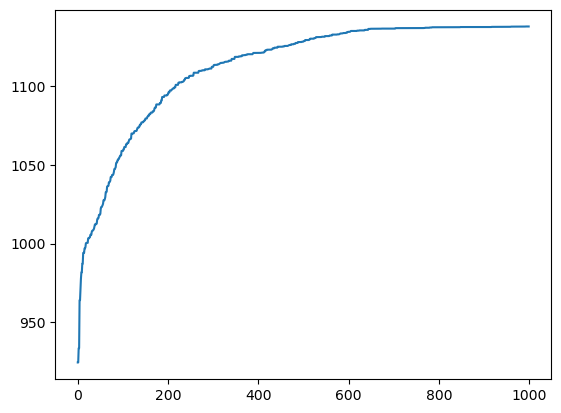

In [18]:
plt.plot(maxfit)


## Challenge 2


The agricultural market in this world is highly variable. This time, you'll be selling your load to a reseller, but you're not sure which one. Each reseller has different prices, so it depends on which one you'll meet. To be prepared, you should explore the possible options.


In [138]:
from multiprocessing.pool import ThreadPool

from pymoo.algorithms.moo.nsga2 import NSGA2, RankAndCrowdingSurvival
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.core.crossover import Crossover
from pymoo.core.mutation import Mutation
from pymoo.core.problem import ElementwiseProblem, StarmapParallelization
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.crossover.ux import UniformCrossover
from pymoo.operators.mutation.pm import PM, PolynomialMutation
from pymoo.operators.repair.rounding import RoundingRepair
from pymoo.operators.sampling.rnd import IntegerRandomSampling
from pymoo.optimize import minimize

from pymoo.core.callback import Callback

from pymoo.core.result import Result

In [20]:
price_a = df["price_A"].to_dict()
price_b = df["price_B"].to_dict()
price_c = df["price_C"].to_dict()

prices = [price_a, price_b, price_c]


Given that cherries have very different prices between the different resellers, the example load we made ealier would fetch a wildly different price depending on the reseller:


In [21]:
a = evaluate(trial_load, stock, weight, price_a)
b = evaluate(trial_load, stock, weight, price_b)
c = evaluate(trial_load, stock, weight, price_c)
print(a, b, c)


600.0000000000001 246.5 374.1


### We'll use **PyMOO** to solve this multi-objective optimization problem
First lets create our class, inheriting from *ElementwiseProblem*: evaluations will be done element by element.

In [92]:
class MarketProblemMultiSeller(ElementwiseProblem):
    stock: npt.NDArray
    weight: npt.NDArray
    prices: pd.DataFrame
    prices_columns: List[str]
    max_weight: int
    xl: npt.NDArray[np.int32]
    xu: npt.NDArray[np.int32]

    def __init__(
        self,
        stock: Dict[str, int],
        weight: Dict[str, int],
        prices: pd.DataFrame,  # dataframe that should contain columns of different prices for the different objectives.
        prices_columns: List[str] = ["price_A", "price_B", "price_C"],
        max_weight=5000,
        **kwargs,
    ):
        self.stock = np.array(list(stock.values()))
        self.weight = np.array(list(weight.values()))
        self.prices = prices
        self.prices_columns = prices_columns
        self.max_weight = max_weight
        self.best_scores = []

        super().__init__(
            n_obj=len(prices_columns),
            n_var=len(stock),
            n_ieq_constr=1,
            xl=np.zeros(len(stock)),
            xu=self.stock,
            **kwargs,
        )


    def _evaluate(self, x, out, *args, **kwargs):
        """evaluates one element on all objectives and constraints"""

        total_weight = np.sum(x * self.weight)

        # store prices for each objective
        total_price = {column: 0 for column in self.prices_columns}

        for column in self.prices_columns:
            for idx, (_, price) in enumerate(self.prices[column].items()):
                total_price[column] += x[idx] * price

        out["F"] = np.array([-price for price in total_price.values()])
        out["G"] = total_weight - self.max_weight
        return
    
    # def _evaluate_elementwise(self, X, out, *args, **kwargs):
    #     super()._evaluate_elementwise(X, out, *args, **kwargs)
    #     self.best_scores.append(np.max(out["F"][:][0]))

    #     for i in range(self.n_obj):
    #         self.callback("pro")


Here we define our mutation class that will do exactly as the mutation used in challenge 1.

In [61]:
class MutateLoad(Mutation):
    def _do(self, problem: MarketProblemMultiSeller, X: npt.NDArray, **kwargs):
        """
        permet d'avoir un chargement voisin qui respecte le stock.
        ne modifie pas load, renvoie une nouvelle instance. inplace

        pour chaque culture ajoute + ou - 1 avec une probabilité proba,
        par défaut 10%, soit 5% pour +1 et 5% pour -1
        """
        threshold = 0.1

        # iterate over all loads contained in X
        for load_idx in range(X.shape[0]):
            probas = np.random.rand(len(X))

            # iterate over all the variables in one load
            for crop_idx, (crop_amount, proba) in enumerate(zip(X[load_idx], probas)):
                if proba < threshold / 2:
                    # check if we can add 1 and still respect max load
                    if crop_amount + 1 <= problem.xu[crop_idx]:
                        X[load_idx][crop_idx] = crop_amount + 1
                elif proba < threshold:
                    # check if we can subtract 1 and not be under 0
                    if crop_amount >= problem.xl[crop_idx] + 1:
                        X[load_idx][crop_idx] = crop_amount - 1

        return X


In [225]:
class SaveBestScores(Callback):
    def __init__(self, n_gen: int, n_objectives: int) -> None:
        # self.n_gen = n_gen
        # self.n_objectives = n_objectives
        # self.best_scores = np.empty((n_gen, n_objectives))

        super().__init__()
    
    def __call__(self, algorithm: NSGA2):
        super(SaveBestScores, self).__call__(algorithm)
        # starts at iter 1, up to n_gen included
        if algorithm.n_iter ==10 :
            print(self.data)
            # print(algorithm.__dict__)
            # print(algorithm.problem.__dict__)
            # print(algorithm.__getattribute__("__out__"))
            print(algorithm.output.__dict__)
            # print(algorithm.output.hv.value)
            # print(algorithm.output.gd.value)
            # print(algorithm.pop.__dict__)

In [284]:
class SaveBestScoresPro:
    n_iter: int
    n_objectives: int
    best_scores: npt.NDArray

    def __init__(self, n_gen: int, n_objectives: int) -> None:
        self.n_iter = 0
        self.n_objectives = n_objectives
        self.best_scores = np.zeros((n_gen, n_objectives + 1))

    def __call__(self, X, out):
        for i in range(self.n_objectives):
            self.best_scores[self.n_iter][i] = max(
                -np.min(out["F"][:, i]), self.best_scores[self.n_iter - 1][i]
            )
        self.best_scores[self.n_iter][-1] = np.sum(self.best_scores[self.n_iter][:-1]) / self.n_objectives

        self.n_iter += 1


We chose the NSGA2 algorithm as it's a great genetic algorithm for multi-objective.

In [285]:
def run_optimization(
    n_gen: int = 1000,
    pop_size: int = 100,
    n_offsprings: int = 100,
    price_objectives=["price_A", "price_B", "price_C"],
    save_history=False,
) -> tuple[Result, npt.NDArray]:
    save_scores = SaveBestScoresPro(n_gen, len(price_objectives))
    # problem = MarketProblemMultiSeller(stock, weight, df, prices_columns=price_objectives)  # type: ignore
    problem = MarketProblemMultiSeller(stock, weight, df, prices_columns=price_objectives, callback=save_scores)  # type: ignore
    algorithm = NSGA2(
        pop_size=pop_size,
        n_offsprings=n_offsprings,
        eliminate_duplicates=True,
        mutation=MutateLoad(),  # type: ignore
        crossover=UniformCrossover(),  # type: ignore
        # this is the same crossover as in challenge 1.
        sampling=IntegerRandomSampling(),  # initial population generation
        # callback = SaveBestScores(n_gen, len(price_objectives) + 1)
    )

    res = minimize(
        problem,
        algorithm,
        termination=("n_gen", n_gen),
        save_history=save_history,
    )

    print("Execution time:", res.exec_time)

    return res, save_scores.best_scores


In [286]:
# res, scores = run_optimization(n_gen=500, pop_size=50, n_offsprings=50, price_objectives=["price_A"])
res, scores = run_optimization(n_gen=500, pop_size=50, n_offsprings=50)


Execution time: 4.374136924743652


In [287]:
scores

array([[ 896.35      ,  448.6       ,  580.2       ,  641.71666667],
       [ 981.2       ,  465.5       ,  599.6       ,  682.1       ],
       [ 981.2       ,  465.5       ,  625.1       ,  690.6       ],
       ...,
       [1157.1       ,  518.        ,  773.2       ,  816.1       ],
       [1157.1       ,  518.        ,  773.2       ,  816.1       ],
       [1157.1       ,  518.        ,  773.2       ,  816.1       ]])

In [137]:
del res

We can see that **the optimization is not that fast**.<br>
Ways of improving it would be to stop using an ElementWise problem and compute the objectives for all the population at once using numpy, instead of iterating through a DataFrame for each element of the population
<br>
The mutation _do function could also be worked on 

In [136]:
# dump the solution
with open("./solution_priceA_obj.pymoo", "wb") as file:
    pickle.dump(res, file)

KeyboardInterrupt: 

In [135]:
print(-np.min(res.F[:, 0]))
print(-np.min(res.F[:, 1]))
print(-np.min(res.F[:, 2]))


1141.95


IndexError: index 1 is out of bounds for axis 1 with size 1

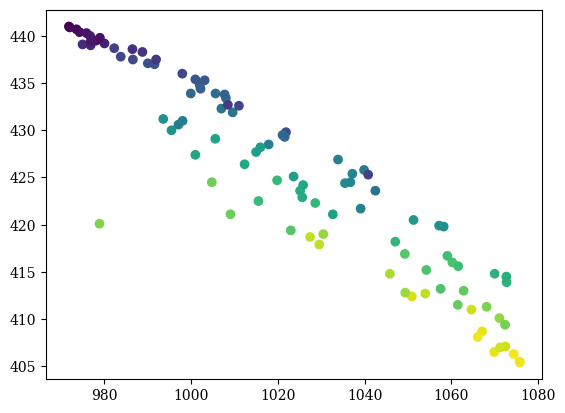

In [126]:
# from pymoo.visualization.scatter import Scatter
# plot = Scatter(tight_layout=True)
# plot.add(-res.F[:, 0:2], s=10, c=-res.F[:, 2])
# plot.add(-res.F[:, 0:2], c=-res.F[:, 2])
# plot.title = "pareto front projected to price_A, price_B objectives"
# plot.show();
plt.scatter(-res.F[:, 0], -res.F[:, 1], c=-res.F[:, 2])

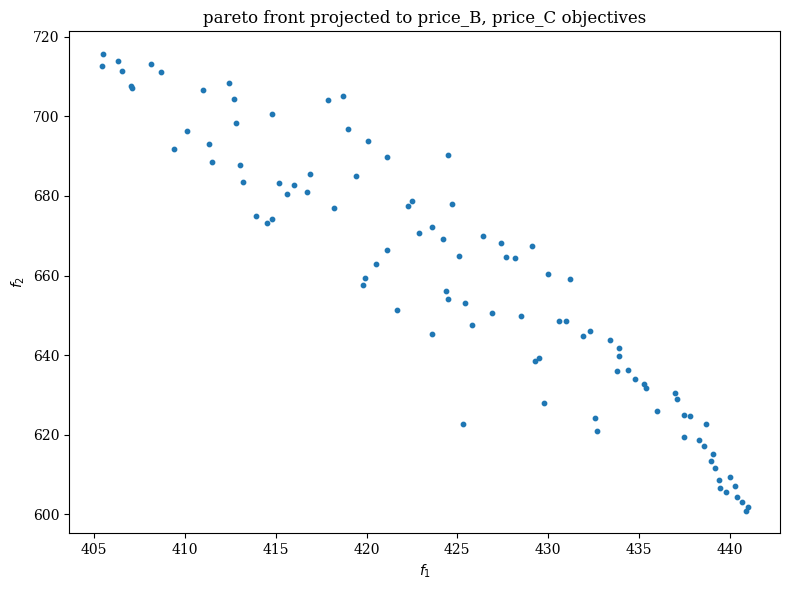

In [127]:
from pymoo.visualization.scatter import Scatter
plot = Scatter(tight_layout=True)
plot.add(-res.F[:, 1::], s=10)
plot.title = "pareto front projected to price_B, price_C objectives"
plot.show();

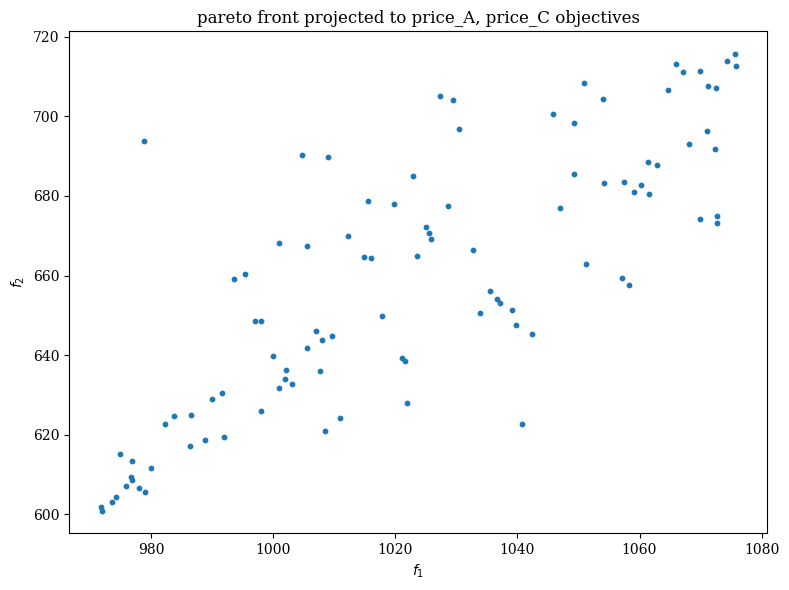

In [128]:
from pymoo.visualization.scatter import Scatter
plot = Scatter(tight_layout=True)
plot.add(-res.F[:, 0::2], s=10)
# plot.add(np.append(-res.F[:, 0], -res.F[:, 2]), s=10)
plot.title = "pareto front projected to price_A, price_C objectives"
plot.show();

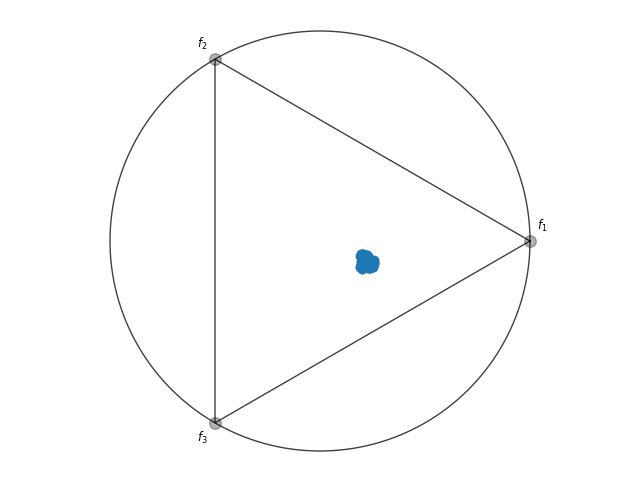

In [112]:
from pymoo.visualization.radviz import Radviz
Radviz().add(res.F).show()


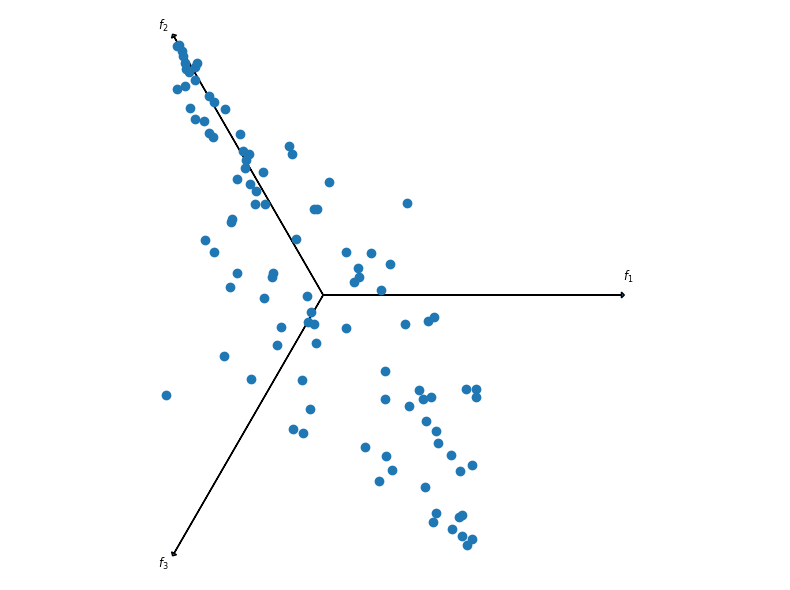

In [129]:
from pymoo.visualization.star_coordinate import StarCoordinate

StarCoordinate(tight_layout = True).add(-res.F).show()


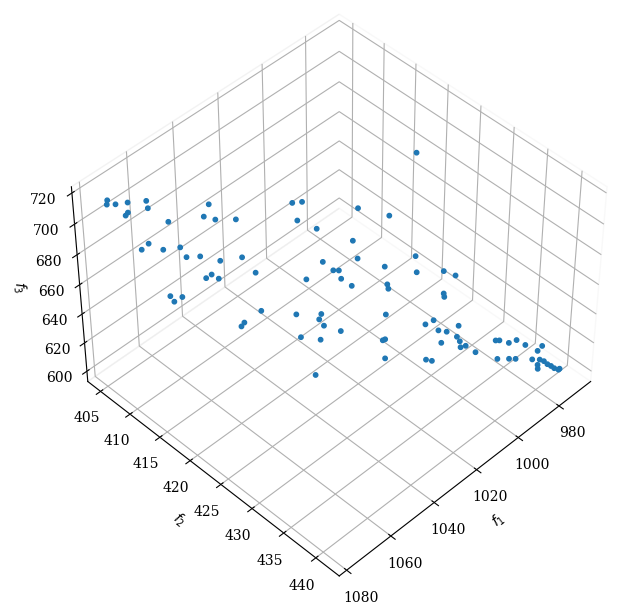

In [130]:
from pymoo.visualization.scatter import Scatter
plot = Scatter(tight_layout=True)
plot.add(-res.F, s=10)
plot.show();

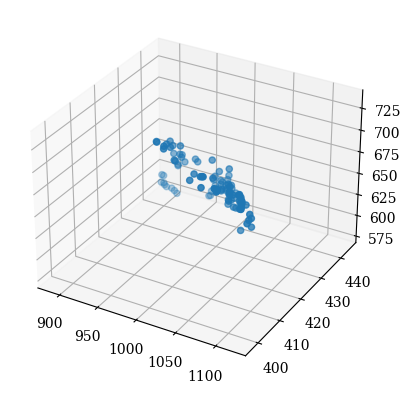

In [115]:
ax = plt.axes(projection='3d')
ax.scatter3D(-res.F[:, 0], -res.F[:, 1], -res.F[:, 2], 'gray')


In [131]:
def is_load_valid(load: npt.NDArray, stock: Dict[str, int], weight: Dict[str, int], max_weight = 5000) -> bool:
    """
    function to check if a proposed load is valid.
    
    mainly for debugging purpose
    """
    load = load.flatten()
    
    if not (len(load) == len(stock) == len(weight)):
        print("dimensions do not correspond")
        return False
    
    total_weight=0

    for idx, (crop_quantity, crop_stock, crop_weight) in enumerate(zip(load, stock.values(), weight.values())):
        if crop_quantity > crop_stock or crop_quantity < 0:
            print(f"crop n°{idx} quantity ({crop_quantity}) does not correspond to stock {crop_stock}.")
            return False
        
        total_weight += crop_quantity * crop_weight

    if total_weight > max_weight:
        print(f"total weight {total_weight} is over max allowed weight of {max_weight}")
        return False
    return True


In [133]:
# Check if solutions are valid
for x in res.X:
    if not is_load_valid(x, stock, weight):
        print(f"{x=} not valid")

Prepare four different options for your market day haul: one option that will be good for reseller A, one for reseller B, one for reseller C, and one which would be pretty good for all three. Display these options and compare their different prices.


Hint: you can use a multi-objective algorithm to optimize for all three reseller prices at the same time.


## Challenge 3


You decide to preprare some of your crops by making food for the market day. You know a number of recipes and are famous for your delicious fruit pies.


In [ ]:
recipes = {
    "Ratatouille": {"Eggplant": 2, "Garlic": 2, "Tomato": 4, "Hot Pepper": 1},
    "Apple Pie": {"Apple": 10, "Wheat": 5},
    "Apricot Pie": {"Apricot": 10, "Wheat": 5},
    "Cherry Pie": {"Cherry": 10, "Wheat": 5},
    "Rhubarb Pie": {"Rhubarb": 10, "Wheat": 5},
    "Strawberry Pie": {"Strawberry": 10, "Wheat": 5},
    "Blackberry Pie": {"Blackberry": 10, "Wheat": 5},
    "Pumpkin Pie": {"Pumpkin": 10, "Wheat": 5},
    "Pizza": {"Tomato": 3, "Wheat": 2, "Artichoke": 1},
    "Baba Ghanoush": {"Eggplant": 2, "Garlic": 4},
    "Squash Soup": {"Yam": 3, "Pumpkin": 1},
    "Peach Beer": {"Hops": 3, "Peach": 1},
    "Blackberry Beer": {"Hops": 3, "Blackberry": 1},
}


These recipes sell for good prices at each of the resellers:


In [ ]:
df = pd.read_csv("recipes.csv", index_col=0)
df.head()


In [ ]:
price_a.update(df["price_A"].to_dict())
price_b.update(df["price_B"].to_dict())
price_c.update(df["price_C"].to_dict())
price_a["Apple Pie"], price_b["Apple Pie"], price_c["Apple Pie"]


Modify the evaluation function to take into account these recipes, making sure not to break the weight or stock constraints. The weight of a recipe is the sum total weight of the ingredients, and you can not make a recipe if you don't have the remaining stock of ingredients. Here's an example of calculating the total weight of a random load of only recipes:


In [ ]:
recipe_load = {}
for k in recipes:
    recipe_load[k] = np.random.randint(0, 5)
recipe_load


In [ ]:
def get_weight(recipe_load, recipes, weight):
    total_weight = 0
    for k in recipe_load:
        ingredients = recipes[k]
        w = 0
        for i in ingredients:
            w += weight[i] * ingredients[i]
        total_weight += w * recipe_load[k]
    return total_weight


In [ ]:
get_weight(recipe_load, recipes, weight)


Once you've modified the evaluation function, rerun the optimization algorithm to find a new load for the three resellers, and one load which is good for all three. Display this result and the profit gained, making sure that the constraints are met.


## Evaluation


You should submit a saved copy of your notebook (including all of the cell output) to the LMS by December 13th, EOD. You may work with one partner, but you must **individually submit a notebook**. You will be graded based on your results, your code, and any text or visual explanations, according to the following rubric:

| Criterion                 | Points |
| ------------------------- | ------ |
| Results - Challenge 1     | 7      |
| Results - Challenge 2     | 5      |
| Results - Challenge 3     | 3      |
| Presentation (code, text) | 5      |
